# Анализ логов поисковых запросов

##  Считываем запросы

In [1106]:
import pandas as pd

data = pd.read_csv('football', sep='\t', index_col=0, nrows=4000000);

In [781]:
# График количества запросов по датам

# data.datetime = pd.to_datetime(data['datetime']).dt.date
# data.groupby('datetime').size()
# data.groupby('datetime').size().plot(figsize=(15,10))

## Считываем и нормализуем ключевые и стоп-слова

In [1107]:
# SnowballStemmer работает быстрыее чем лемматизатор pymorphy2 примерно в 3 раза

# Если использовать лемматизатор, то надо лемматизировать и запросы
# Так как этот алгоритм работал дольше, я решил не лемматизировать запросы
# А сделать выборку по стеммам ключевых и стоп-слов

import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

# Считываем ключевые и стоп-слова из файлов
# И удаляем пустые строки

# Ключевые слова я определил сам, потому что
# Стеммер определял стеммы для слишком большого количества слов 
words = [word.rstrip() for word in open("words", "r").readlines()]
words = list(filter(None, words))

stop_words = [word.rstrip() for word in open("minus_words", "r").readlines()]
stop_words = list(filter(None, stop_words))

# Стоп-слова обрабатываем стеммеров
stop_words[:] = [stemmer.stem(word) for word in stop_words]

## Фильтруем запросы по ключевым и стоп-словам

In [1108]:
# %%time

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

arr = pd.DataFrame(columns=['original', 'lemm']);
X = None;

for i, item in data.iterrows():
    i = str(i)
    
    # Анализируем запросы не длиннее 100 символов
    if len(i) < 100:
        temp_item = i # [morph.parse(word)[0].normal_form for word in i.split()]
     
        if any(word in temp_item for word in words):
            
            # Добавляем запрос в выборку, если он не содержит стоп-слов                        
            if not any(stop_word in temp_item for stop_word in stop_words):
                
                # Лемматизируем запросы для векторизации
                lemm = [morph.parse(word)[0].normal_form for word in i.split()]
                arr = arr.append({'original': i, 'lemm': i}, ignore_index=True)

## Векторизуем запросы

In [1109]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(min_df = 1)

X = tfidf_v.fit_transform(arr.lemm.values)

# Размерность матрицы
print(X.shape)

(150788, 37408)


In [1012]:
# Матрица векторов

# data2 = pd.DataFrame(data=X.toarray(), columns=tfidf_v.get_feature_names(), index=arr.original)
# data2

In [1111]:
# Словарь
# Можно поискать стоп-слова

# print(tfidf_v.get_feature_names())

## Кластеризуем запросы

CPU times: user 31min 58s, sys: 29.8 s, total: 32min 28s
Wall time: 34min 27s


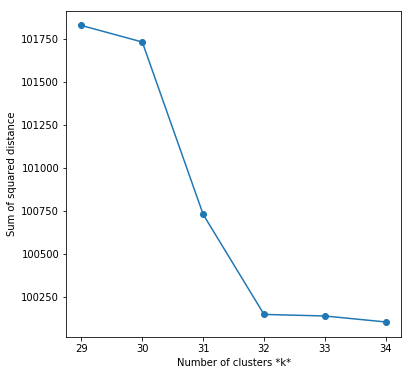

In [1117]:
# %%time

# Определяем оптимальное количество кластеров

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

sse = []
list_k = list(range(29, 35))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [1118]:
# Кластеризуем запросы

CLUSTERS = 32

k_means = KMeans(
    n_clusters=int(CLUSTERS),
    init='k-means++',
    n_init=10,
    max_iter=500,
    tol=0.0001,
    n_jobs=4)

clusters = k_means.fit(X)

In [1119]:
# Записываем кластеры в словарь

dct = {}

for key, label in zip(arr.original, k_means.labels_):
    dct[label] = dct.get(label, [])+[key]

In [1166]:
# Вывести все кластеры

# for item in dct:
#     print(dct[item])
#     print('\n' + '='*100 + '\n')

In [1164]:
# Находим топ-N запросов из кластеров

from collections import Counter

TOP_N = 10

for n in dct:
    cnts = Counter(item for item in dct[n])

    print('Кластер:', n, 'Всего элементов:', len(dct[n]))

    # Находим самых частых запросов
    for item in cnts.most_common(TOP_N):
        print(item)
    
    print('\n')

Кластер: Матчи, Исландия Всего элементов: 1481
('аргентина исландия 16 июня 2018', 187)
('аргентина исландия', 177)
('исландия', 126)
('аргентина исландия 16 июня', 102)
('нигерия исландия 22 июня 2018', 73)
('нигерия исландия 22 июня', 70)
('хорватия нигерия 16 июня 2018', 56)
('хорватия нигерия 16 июня', 49)
('исландия хорватия 26 июня', 45)
('хорватия исландия', 42)


Кластер: Чемпионат мира по футболу 2018 Всего элементов: 8979
('чемпионат мира по футболу 2018', 6704)
('чемпионат мира по футболу', 612)
('чемпионат мира', 295)
('футбол чемпионат мира 2018', 230)
('чемпионат мира 2018', 58)
('чемпионат мира по футболу 2018 сборная россии', 47)
('билеты на чемпионат мира по футболу 2018', 36)
('смотреть чемпионат мира по футболу 2018', 26)
('чемпионат мира по футболу 2018 онлайн', 21)
('чемпионат мира по футболу 2018 группы', 18)


Кластер: ЧМ 2018 Всего элементов: 2421
('чм 2018', 701)
('чм', 603)
('матчи чм 2018', 74)
('группы чм 2018', 53)
('сетка чм 2018', 47)
('таблица чм 2018', 

In [1152]:
# Переименовываю кластеры по смыслу их запросов

# dct['Матчи, Исландия'] = dct.pop(18)
# dct['Чемпионат мира по футболу 2018'] = dct.pop(4)
# dct['ЧМ 2018'] = dct.pop(9)
# dct['Матчи разных стран'] = dct.pop(8)
# dct['Матчи разных стран: португалия, испания, марокко, иран'] = dct.pop(23)
# dct['ФИФА: рейтинг, билеты, расписание'] = dct.pop(31)
# dct['Расписание матчей, игр'] = dct.pop(6)
# dct['Каналы, прямой эфир'] = dct.pop(17)
# dct['Россия Испания'] = dct.pop(2)
# dct['ЧМ по футболу, команды на чм, расписание'] = dct.pop(24)
# dct['Матч ТВ, матч'] = dct.pop(29)
# dct['Сборные'] = dct.pop(22)
# dct['Футбол'] = dct.pop(3)
# dct['Чемпионат мира расписание'] = dct.pop(30)
# dct['Матчи разных стран: бельгия, англия, хорватия, швеция, колумбия, панама, тунис'] = dct.pop(5)
# dct['Матчи разных стран: франция, хорватия, бельгия, уругвай, бразилия, япония'] = dct.pop(11)
# dct['Билеты'] = dct.pop(27)
# dct['прямой эфир'] = dct.pop(13)
# dct['Смотреть прямой эфир'] = dct.pop(25)
# dct['Матчи разных стран: россия, египет, уругвай'] = dct.pop(12)
# dct['Россия Хорватия'] = dct.pop(26)
# dct['Матчи разных стран: россия, уругвай, франция, португалия'] = dct.pop(15)
# dct['Матчи разных стран: япония, сенегал, польша, колумбия, '] = dct.pop(28)
# dct['Матчи разных стран: франция, аргентина, уругвай, португалия, хорватия, перу, нигерия, ямайка, испания'] = dct.pop(21)
# dct['Прямая трансляция, онлайн, трансляция'] = dct.pop(16)
# dct['Расписание, сетка, таблица, график'] = dct.pop(1)
# dct['Смотреть онлайн'] = dct.pop(7)
# dct['Матчи разных стран: хорватия, дания, перу, франция'] = dct.pop(10)
# dct['Футболист'] = dct.pop(14)
# dct['Результаты'] = dct.pop(20)
# dct['Во сколько футбол, матч, игра'] = dct.pop(19)
# dct['Разные запросы'] = dct.pop(0)




























